## Дерево решений

Задание
1. Построить геометрическую интерпретацию критерия Джини()
2. Применить дерево решений из sklearn для задачи Titanic на kaggle (заполнив пропуски).  
Применить кросс-валидацию для подбора параметров и выбрать лучшие(например с помощью **GridSearchCV** из sklearn).  
Написать отчет о результатах.

In [219]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [220]:
train = pd.read_csv('else/titanic-43529-840b22/train.csv', sep=',')
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [221]:
test = pd.read_csv('else/titanic-43529-840b22/test.csv', sep=',')
test_targets = pd.read_csv('else/titanic-43529-840b22/gender_submission.csv', sep=',')
test = test.assign(Survived = test_targets.Survived)
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [222]:
print(f'train shape - {train.shape}')
print(f'test shape - {test.shape}')

train shape - (891, 12)
test shape - (418, 12)


## Бейзлайн Титаника 

In [223]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

pipeline = Pipeline(steps = [('imputer', SimpleImputer()),
                             ('scaler',StandardScaler()),
                             ('tree',DecisionTreeClassifier())])
grid = {
    'tree__criterion' : ['gini', 'entropy'],
    'tree__max_depth' : [2,5],  
}
gridsearch = GridSearchCV(pipeline, grid, cv = 3)     
gridsearch.fit(np.array(train.loc[:,features]), np.array(train.Survived))
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                        max_depth=5, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],


In [224]:
gridsearch.best_score_

0.7115600448933782

In [225]:
accuracy_score(y_pred = gridsearch.predict(np.array(test[features])), y_true = test.Survived)

0.6746411483253588

## 1. Геометрическая интерпретация критерия Джини 

**Задание** Построить график кривой Лоренца (https://habr.com/ru/company/ods/blog/350440/ - абзац с машиным обучением) 
            для дерева решений с разделением по критерию Джини, используя бейзлайн.

**Пример**

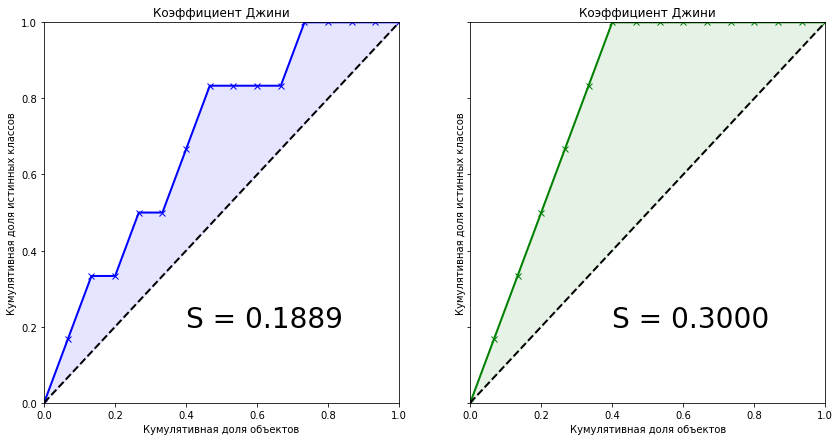

In [226]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predict = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values)[0] - 0.5

fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_values, lw = 2, color = 'blue', marker='x')
ax[0].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_values_perfect, lw = 2, color = 'green', marker='x')
ax[1].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

## 2. Контест Титаник

Побейте безлайн с помощью дерева решений(почерпнуть идеи можно из  
https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem,  
но модель в этом задание ограничивается деревом решений), выполните следующие пункты.  
Выберите наиболее сильную модель. Напишите отчет о результатах.


- Придумайте, как нужно использовать дополнительные признаки.
- Примените One-hot-encoding для категориальных признаков.
- Заполнить пропуски
- Применить кроссвалидацию
- отобрать параметры, например с помощью GridSearchCV

#### -----------------------------------------------------------------------------------------------------------------
Для начала посмотрим, в каких фичах у нас есть пропущенные значения на train и test датасетах

In [227]:
nans = pd.concat([train.isnull().sum(),test.isnull().sum()], axis=1)
nans[(nans[0] != 0) | (nans[1] != 0)]

,0,1
Age,177,86
Cabin,687,327
Embarked,2,0
Fare,0,1


1) Age:
    
Для возраста заменим пропуски на рандомные значения в диапазоне 1 стандартного отклонения от среднего

In [228]:
train_r_ages = np.random.randint(train["Age"].mean() - train["Age"].std(),
                                          train["Age"].mean() + train["Age"].std(),
                                          size = train["Age"].isnull().sum())

test_r_ages = np.random.randint(test["Age"].mean() - test["Age"].std(),
                                          test["Age"].mean() + test["Age"].std(),
                                          size = test["Age"].isnull().sum())

train["Age"][np.isnan(train["Age"])] = train_r_ages
test["Age"][np.isnan(test["Age"])] = test_r_ages
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

2) Cabin

Пропущенные значения Cabin заменим на "_", а от существующих оставим только первые буквы - обозначение палубы. Также посмотрим, как располагаются палубы на корабле

In [229]:
chars=[]
for df in [train, test]:
    df['Cabin'] = df['Cabin'].fillna('_')
    df['Cabin'] = np.array(df.Cabin.map(lambda x: str(x)[0])).reshape(-1,1)
    chars.append(df['Cabin'].unique().tolist())
chars

[['_', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'],
 ['_', 'B', 'E', 'A', 'C', 'D', 'F', 'G']]

<img src="https://upload.wikimedia.org/wikipedia/commons/8/84/Titanic_cutaway_diagram.png">

Судя по всему значение $T$ - ошибка в данных, оно встречается в выборке всего 1 раз, а на чертежах отсутствует.

In [230]:
cabins = pd.concat([train, test], axis=0)
cabin_T = cabins[cabins.Cabin == 'T']
cabin_T

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
339,45,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,0,113784


Соединим палубы по группам: A - две верхних палубы, B - две средних, C - три нижних. Значение $T$ положим в последнюю

In [231]:
for df in [train, test]:
    df['Cabin'] = df['Cabin'].replace(['A', 'B'], 'A')
    df['Cabin'] = df['Cabin'].replace(['C', 'D'], 'B')
    df['Cabin'] = df['Cabin'].replace(['E', 'F', 'G', 'T'], 'C')

3) Embarked:

Поскольку S встречается чаще всего, то пропуски в Embarked заменим значением S (далее применим OneHot). 

In [232]:
train.groupby('Embarked').agg({'Name':'count'})

,Name
Embarked,
C,168
Q,77
S,644


In [233]:
for df in [train, test]:
    df.Embarked=df.Embarked.fillna('S')

4) Fare: пропуск в стоимости билета заполним медианным значением ниже, во время выполнения pipeline

Добавим дополнительную фичу: информацию о том, сколько родных было на борту с пассажиром, включая его самого

In [234]:
for df in [train, test]:
    df['Family_size'] = df.SibSp + df.Parch + 1

Каюты закодируем при помощи LabelEncoder

In [235]:
from sklearn.preprocessing import LabelEncoder

for df in [train, test]:
    df['Cabin']= LabelEncoder().fit_transform(df['Cabin'])

Остальные категориальные фичи закодируем OneHot-ом, отнормируем фичи Age и созданную Family_size

In [236]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score

def cabin(df):
    return df[['Cabin']]

def sex_pclass_embarked(df):
    return df[['Sex', 'Pclass', 'Embarked']]

def age_family(df):
    return df[['Age', 'Family_size']]

def fare(df):
    return df[['Fare']]

pipe = make_union(*[
    make_pipeline(FunctionTransformer(sex_pclass_embarked, validate=False), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(cabin, validate=False)),
    make_pipeline(FunctionTransformer(age_family, validate=False), StandardScaler()),
    make_pipeline(FunctionTransformer(fare, validate=False), SimpleImputer(strategy = 'median'), StandardScaler()),
                   ])
X = pipe.fit_transform(train)
X_test = pipe.fit_transform(test)

Нагенерируем в выборку новых фичей при помощи PolynomialFeatures и затем применим деревья решений. Глубину попробуем варьировать от 2 до 7, кроссвалидацию осуществим на 10 фолдах

In [237]:
pipe_tree = Pipeline(steps = [('poly', PolynomialFeatures()),
                             ('tree',DecisionTreeClassifier(random_state=0))])

grid = {
    'tree__criterion' : ['gini'],
    'tree__max_depth' : np.arange(2,8),  
}
gridsearch = GridSearchCV(pipe_tree, grid, cv = 10)     
gridsearch.fit(X, np.array(train.Survived))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
      

In [247]:
Y_test_pred = gridsearch.predict(np.array(X_test))
Y_test_pred_proba = gridsearch.predict_proba(np.array(X_test))
Y_test = test.Survived

print(gridsearch.best_estimator_)
print('\nbest score ' + str(gridsearch.best_score_))
print('accuracy score ' + str(accuracy_score(y_pred = Y_test_pred, y_true = Y_test)))

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('tree',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=0,
                                        splitter='best'))],
         verbose=False)

best score 0.8047138047138047
accuracy score 0.9736842105263158


В итоге получили наилучший результат при глубине дерева 3, accuracy = 0.97, средняя оценка на кроссвалидации = 0.80

## 3. Кривая Лоренца

Найдите лучшую модель с использованием Джини и постройте для нее кривую Лоренца,  
сравните с кривой для бейзлайновой модели

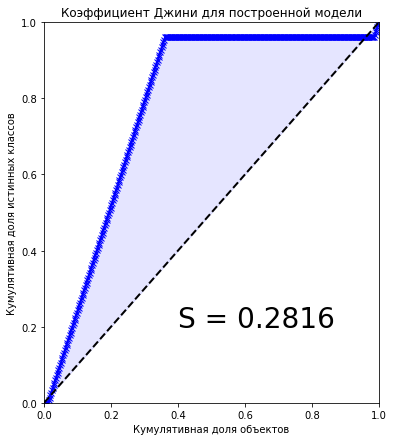

In [269]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

# -----Prepare data for plotting Lorenz (Lift) curves-----
# Mix together predicted probabilities and true outputs and sort by predicted probabilities
lorenz_df = pd.DataFrame({'true':Y_test, 'pred_proba':Y_test_pred_proba[:,1]})
lorenz_df = lorenz_df.sort_values('pred_proba', ascending = False)

# Count cumulative sum for: true values in sorted lorenz_df, and not sorted true values
cum_pred = np.cumsum(lorenz_df.true) / sum(Y_test)

# Create indices for Ox in future plots
ind = np.arange(1, len(cum_pred)+1) / len(cum_pred)

# Shape x and y for plotting "Lift Curve for true" and "Lift Curve for predicted"
x = [0] + list(ind)
y_pred = [0] + list(cum_pred)

# -----Prepare gini values-----
# Interpolate function, using our points
f = interp1d(x, y_pred)

# Find difference betweend y=x and Lorenz curve
S_pred = quad(f, 0, 1)[0] - 0.5 

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6, 7))
ax.plot(x, y_pred, lw = 2, color = 'blue', marker='x')
ax.fill_between(x, x, y_pred, color = 'blue', alpha=0.1)
ax.text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)

ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
ax.set(title='Коэффициент Джини для построенной модели', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

Для бейзлайн модели S = 0.1889, в идеале S = 0.3000, а в нашей построенной модели S = 0.2816.

Нормализованный gini для построенной модели = .93 (=.2816/.3), а для бейзлайна = .63 (=.2816/.3), то есть построенная модель работает лучше, чем бейзлайн.